In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

ds = pd.read_csv("/Users/felipearredondo/dev/uni/data-science-project/data_source/salaries_data_unified.csv")

In [13]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477 entries, 0 to 5476
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   work_year           5477 non-null   int64
 1   experience_level    5477 non-null   int64
 2   employment_type     5477 non-null   int64
 3   job_title           5477 non-null   int64
 4   salary              5477 non-null   int64
 5   salary_currency     5477 non-null   int64
 6   salary_in_usd       5477 non-null   int64
 7   employee_residence  5477 non-null   int64
 8   company_location    5477 non-null   int64
 9   company_size        5477 non-null   int64
 10  work_setting        5477 non-null   int64
dtypes: int64(11)
memory usage: 470.8 KB


### 1. Creacion de clusters en base al salario

In [14]:
salary_bins = [0, 50000, 100000, 150000, float('inf')]
salary_labels = ['Low', 'Medium', 'High', 'Very High']

In [15]:
ds['salary_range'] = pd.cut(ds['salary_in_usd'], bins=salary_bins, labels=salary_labels)
X = ds.drop(['salary', 'salary_in_usd', 'salary_currency', 'salary_range'], axis=1)
if 'cluster' in X.columns:
    X = X.drop('cluster', axis=1)
    
y = ds['salary_range']

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2. Caracteristicas y su importancia (Previo al PCA)

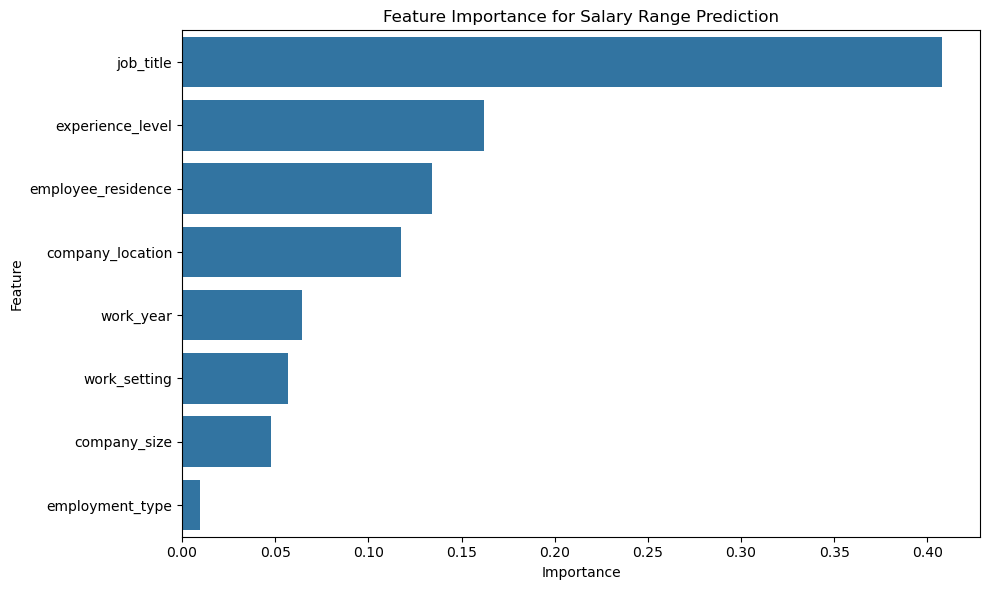

In [18]:
model_without_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])
model_without_pca.fit(X_train, y_train)

# Get feature importance
importances = model_without_pca.named_steps['classifier'].feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Salary Range Prediction')
plt.tight_layout()
plt.show()

### Eliminacion de caracteristicas que no aportan lo suficiente

In [19]:
X = X.drop(["employment_type", "company_size", "work_setting", "work_year"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 3. Random Forest Classifier con PCA

Classification Report:
              precision    recall  f1-score   support

        High       0.46      0.30      0.36       521
         Low       0.67      0.47      0.55       110
      Medium       0.51      0.50      0.51       349
   Very High       0.61      0.81      0.70       664

    accuracy                           0.56      1644
   macro avg       0.56      0.52      0.53      1644
weighted avg       0.55      0.56      0.54      1644



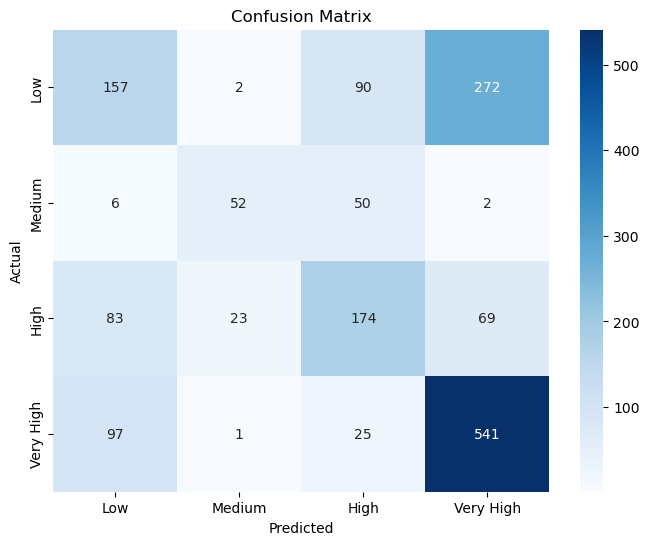

Accuraccy = 0.56
Mejor precisión RF: 0.5580
Mejores parámetros RF: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [26]:

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 5. Train the model
pipeline.fit(X_train, y_train)

# 6. Evaluate the model
y_pred = pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=salary_labels, yticklabels=salary_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuraccy = {accuracy:.2}")

param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, param_grid_rf, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Mejor precisión RF: {grid_search.best_score_:.4f}")
print(f"Mejores parámetros RF: {grid_search.best_params_}")

### 4. Modelo de Regresion Logistica

Classification Report:
              precision    recall  f1-score   support

        High       0.40      0.07      0.11       521
         Low       0.67      0.18      0.29       110
      Medium       0.39      0.50      0.44       349
   Very High       0.53      0.86      0.65       664

    accuracy                           0.49      1644
   macro avg       0.50      0.40      0.37      1644
weighted avg       0.47      0.49      0.41      1644



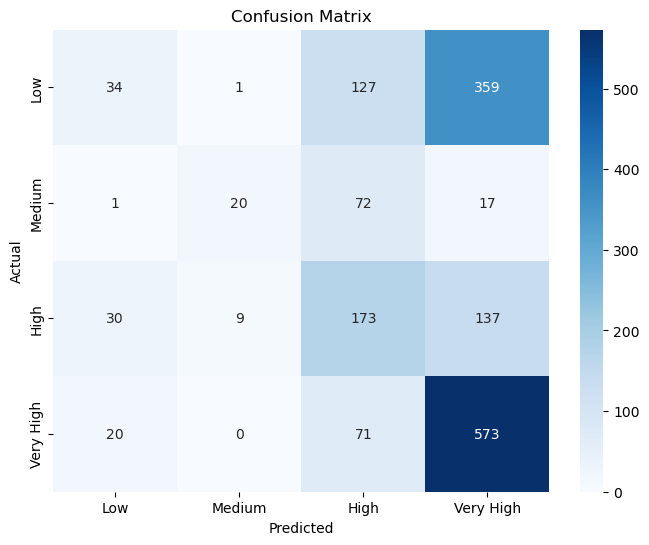

Accuraccy = 0.49
Mejor precisión LR: 0.4941
Mejores parámetros LR: {'classifier__C': 10, 'classifier__max_iter': 10000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


In [22]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=10000))
])

# Entrena el modelo
pipeline_lr.fit(X_train, y_train)

# Evalúa el modelo
y_pred = pipeline_lr.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=salary_labels, yticklabels=salary_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuraccy = {accuracy:.2}")

param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [10000]
}

# Crea un nuevo GridSearchCV para la regresión logística
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)
print(f"Mejor precisión LR: {grid_search_lr.best_score_:.4f}")
print(f"Mejores parámetros LR: {grid_search_lr.best_params_}")

### 5. Support Vector Classifier

Classification Report:
              precision    recall  f1-score   support

        High       0.39      0.09      0.15       521
         Low       0.58      0.36      0.45       110
      Medium       0.42      0.49      0.45       349
   Very High       0.54      0.86      0.67       664

    accuracy                           0.50      1644
   macro avg       0.48      0.45      0.43      1644
weighted avg       0.47      0.50      0.44      1644



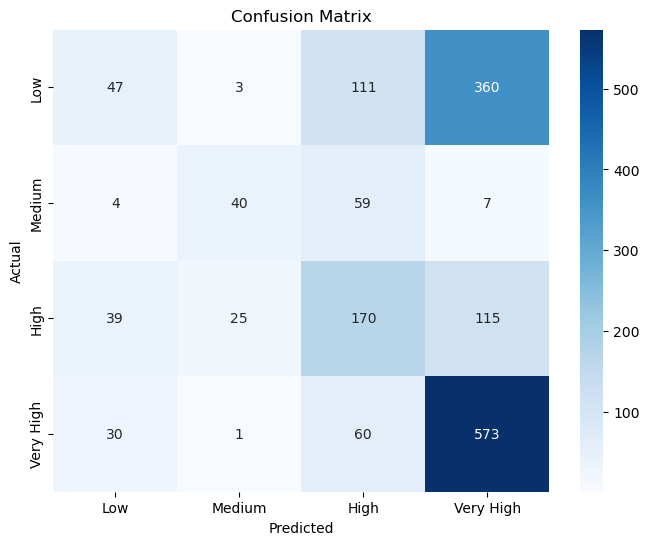

Accuraccy = 0.5
Mejor precisión SVC: 0.5320
Mejores parámetros SVC: {'classifier__C': 10, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}


In [23]:
### 5. Modelo SVC (Support Vector Classifier)
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42))
])

# Entrena el modelo
pipeline_svc.fit(X_train, y_train)

# Evalúa el modelo
y_pred = pipeline_svc.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=salary_labels, yticklabels=salary_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuraccy = {accuracy:.2}")

param_grid_svc = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.1, 1],
    'classifier__kernel': ['rbf', 'linear']
}

# Crea un nuevo GridSearchCV para SVC
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc.fit(X_train, y_train)
print(f"Mejor precisión SVC: {grid_search_svc.best_score_:.4f}")
print(f"Mejores parámetros SVC: {grid_search_svc.best_params_}")

### 6. KNN Classifier

Classification Report:
              precision    recall  f1-score   support

        High       0.41      0.30      0.34       521
         Low       0.57      0.46      0.51       110
      Medium       0.43      0.42      0.43       349
   Very High       0.59      0.75      0.66       664

    accuracy                           0.52      1644
   macro avg       0.50      0.48      0.49      1644
weighted avg       0.50      0.52      0.50      1644



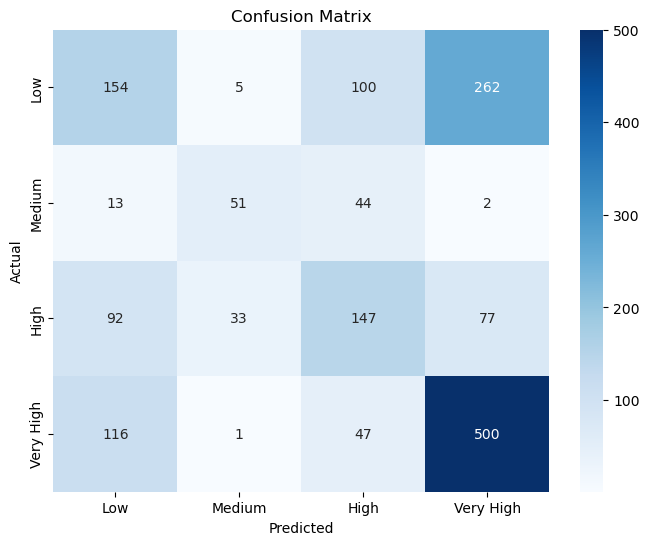

Accuraccy = 0.52
Mejor precisión KNN: 0.5393
Mejores parámetros KNN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__weights': 'distance'}


In [24]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

# Entrena el modelo
pipeline_knn.fit(X_train, y_train)

# Evalúa el modelo
y_pred = pipeline_knn.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=salary_labels, yticklabels=salary_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuraccy = {accuracy:.2}")

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 15],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Crea un nuevo GridSearchCV para KNN
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)
print(f"Mejor precisión KNN: {grid_search_knn.best_score_:.4f}")
print(f"Mejores parámetros KNN: {grid_search_knn.best_params_}")

## Comparacion de modelos

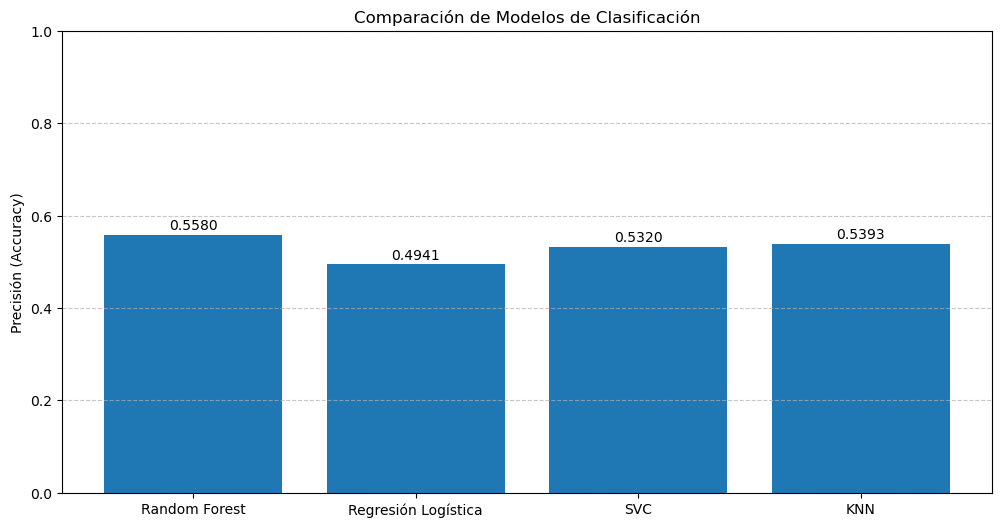

El mejor modelo es: Random Forest con precisión 0.5580


In [28]:
### 8. Comparación de todos los modelos

# Recolectar resultados de todos los modelos
modelos = {
    'Random Forest': grid_search.best_score_,
    'Regresión Logística': grid_search_lr.best_score_,
    'SVC': grid_search_svc.best_score_,
    'KNN': grid_search_knn.best_score_
}

# Visualizar resultados
plt.figure(figsize=(12, 6))
bars = plt.bar(modelos.keys(), modelos.values())

# Añadir etiquetas de valores
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.4f}', ha='center', va='bottom')

plt.ylabel('Precisión (Accuracy)')
plt.title('Comparación de Modelos de Clasificación')
plt.ylim(0, 1.0)  # Establecer rango del eje y
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Mostrar el mejor modelo
mejor_modelo = max(modelos.items(), key=lambda x: x[1])
print(f"El mejor modelo es: {mejor_modelo[0]} con precisión {mejor_modelo[1]:.4f}")